#Download Dataset

In [1]:
!git clone "https://github.com/muhammadikhsan94/challenge-3"

fatal: destination path 'challenge-3' already exists and is not an empty directory.


#Import Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

#Data

In [3]:
df = pd.read_csv("/content/challenge-3/train.csv", encoding='latin-1')
df = df[['Tweet', 'HS']]
df.head(2)

,Tweet,HS
0,- disaat semua cowok berusaha melacak perhatia...,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   13169 non-null  object
 1   HS      13169 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 205.9+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


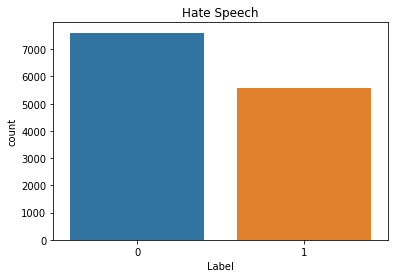

In [5]:
sns.countplot(df.HS)
plt.xlabel('Label') # 0 = No Hate Speech, 1 = Hate Speech
plt.title('Hate Speech')
plt.show()

#Kamus Bahasa

In [6]:
kata_alay = pd.read_csv("/content/challenge-3/kamus_alay.csv", encoding='latin-1', header=None)
kata_alay = kata_alay.rename(columns={0: "Original", 1: "Replacement"})
kata_alay

,Original,Replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [7]:
stopword_dict = pd.read_csv("/content/challenge-3/stopwordbahasa.csv", header=None)
stopword_dict = stopword_dict.rename(columns={0: "stopword"})
stopword_dict

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak
...,...
753,wong
754,yaitu
755,yakin
756,yakni


In [8]:
# Install Library
!pip install PySastrawi

import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text)
    text = re.sub('rt',' ',text)
    text = re.sub('user',' ',text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub('  +', ' ', text)
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

kata_alay_map = dict(zip(kata_alay['Original'], kata_alay['Replacement']))
def normalize_alay(text):
    return ' '.join([kata_alay_map[word] if word in kata_alay_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text)
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

#Preprocessing

In [9]:
def preprocess(text):

    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text)
    text = stemming(text)
    text = remove_stopword(text)
    
    return text

In [10]:
df['Tweet'] = df['Tweet'].apply(preprocess)
df.head(2)

,Tweet,HS
0,cowok usaha lacak perhati gue lantas remeh per...,1
1,telat tau edan sarap gue gaul cigax jifla cal ...,0


#Tokenisasi

In [11]:
X = df.Tweet
Y = df.HS

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenisasi = Tokenizer(num_words=1000)
tokenisasi.fit_on_texts(X)
sequences = tokenisasi.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=100)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(sequences_matrix, Y, test_size=0.2, shuffle=True)
X_train.shape

(10535, 100)

#Training Model

In [14]:
def RNN():
    inputs = Input(name='inputs',shape=[100])
    layer = Embedding(1000, 50, input_length=1000)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [15]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               33024     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

In [16]:
checkpoint = ModelCheckpoint("/content/best_model.hdf5", monitor="accuracy", verbose=1, mode='max')
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val), 
                    callbacks=[checkpoint])

Epoch 1/10
82/83 [============================>.] - ETA: 0s - loss: 0.5680 - accuracy: 0.6894
Epoch 00001: saving model to /content/best_model.hdf5
83/83 [==============================] - 1s 17ms/step - loss: 0.5673 - accuracy: 0.6900 - val_loss: 0.4255 - val_accuracy: 0.7965
Epoch 2/10
82/83 [============================>.] - ETA: 0s - loss: 0.3813 - accuracy: 0.8311
Epoch 00002: saving model to /content/best_model.hdf5
83/83 [==============================] - 1s 11ms/step - loss: 0.3812 - accuracy: 0.8312 - val_loss: 0.4029 - val_accuracy: 0.8166
Epoch 3/10
79/83 [===========================>..] - ETA: 0s - loss: 0.3532 - accuracy: 0.8439
Epoch 00003: saving model to /content/best_model.hdf5
83/83 [==============================] - 1s 11ms/step - loss: 0.3533 - accuracy: 0.8442 - val_loss: 0.4135 - val_accuracy: 0.8132
Epoch 4/10
82/83 [============================>.] - ETA: 0s - loss: 0.3404 - accuracy: 0.8544
Epoch 00004: saving model to /content/best_model.hdf5
83/83 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


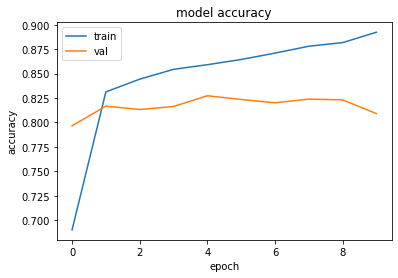

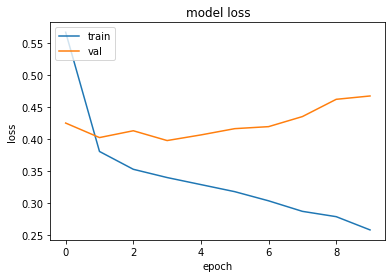

In [17]:
# Plot accuracy & loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='bottom left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#Testing Model

In [18]:
df_test = pd.read_csv("/content/challenge-3/test.csv", delimiter=";", encoding='latin-1')
df_test = df_test[['Tweet', 'HS']]
df_test.head()

,Tweet,HS
0,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1
1,Sakit jiwa kali yah..,0
2,"Does insulting one for being ""Cina"", ""Kafir"", ...",0
3,USER USER Karena partaimu pdip itu bajingan',1
4,USER USER Jgn salah itu janji jokowi yg di tun...,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


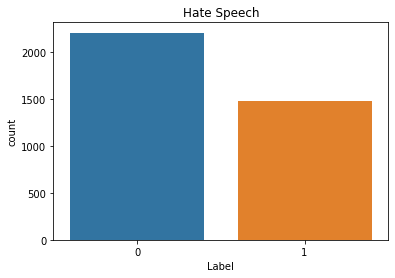

In [19]:
sns.countplot(df_test.HS)
plt.xlabel('Label')
plt.title('Hate Speech')
plt.show()

In [20]:
df_test['Tweet'] = df_test['Tweet'].apply(preprocess)
df_test.head(2)

,Tweet,HS
0,ganteng berengsek who do think are re nothing ...,1
1,sakit jiwa kali ya,0


In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   3680 non-null   object
 1   HS      3680 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.6+ KB


In [22]:
data_test = df_test.Tweet
test_sequences = tokenisasi.texts_to_sequences(data_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=100)

In [23]:
y_test = df_test.HS

pred = model.evaluate(test_sequences_matrix, y_test)
print("Accuracy = {}\nLoss = {}".format(pred[1], pred[0]))

115/115 [==============================] - 1s 5ms/step - loss: 0.5312 - accuracy: 0.7973
Accuracy = 0.7972826361656189
Loss = 0.5312195420265198


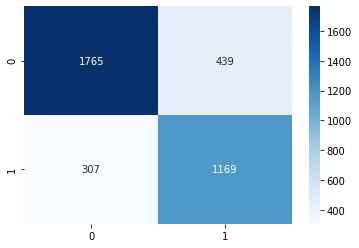

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      2204
           1       0.73      0.79      0.76      1476

    accuracy                           0.80      3680
   macro avg       0.79      0.80      0.79      3680
weighted avg       0.80      0.80      0.80      3680



In [24]:
prediksi = model.predict(test_sequences_matrix)

out_prediksi = []
for x in prediksi:
    if x < 0.5:
        out_prediksi.append(0)
    else:
        out_prediksi.append(1)

acc = confusion_matrix(y_test, out_prediksi)

sns.heatmap(acc, annot=True, fmt='.0f', cmap='Blues')
plt.show()

print(classification_report(y_test, out_prediksi))